✅ TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING

10 Academy Week 10 Challenge

Objective

To validate historical financial inclusion trends and quantify the projected impact of policy and infrastructure events using structured event–indicator linkages and lag-aware modeling.

rewrite all Task 3 cells from your notebook fully modular and professional, with proper cell splitting and dependencies, so you can just run them top-

In [43]:
# Cell 1 – Imports & Global Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from datetime import datetime
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 140
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

PROJECT_ROOT = Path(os.getcwd()).parent.absolute()
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR   = PROJECT_ROOT / 'reports' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

ENRICHED_PATH = PROCESSED_DIR / 'enriched_fi_unified_data.csv'

# Robust mapping
MAGNITUDE_MAP = {
    'very high': 4.0, 'high': 3.0, 'medium': 2.0, 'low': 1.0,
    'none': 0.0, 'unknown': 0.0
}
DIRECTION_MAP = {
    'increase': 1.0, 'positive': 1.0, '+': 1.0, 'up': 1.0,
    'decrease': -1.0, 'negative': -1.0, '-': -1.0, 'down': -1.0,
    'neutral': 0.0, 'no change': 0.0
}

print("TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING")
print(f"Project root: {PROJECT_ROOT}")
print(f"Input:        {ENRICHED_PATH}")
print(f"Figures:      {FIGURES_DIR}")

TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING
Project root: c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast
Input:        c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\data\processed\enriched_fi_unified_data.csv
Figures:      c:\Users\JERUSALEM\ethiopia-financial-inclusion-forecast\reports\figures


In [44]:
# Cell 2 – Load & Split Data
def load_and_split_data(path=ENRICHED_PATH):
    """Load enriched CSV and split into observations/events/impact_links."""
    if not path.exists():
        raise FileNotFoundError(f"Enriched data missing: {path}. Run Task 1 first.")
    
    df = pd.read_csv(path, low_memory=False)
    df.columns = df.columns.str.strip().str.lower().str.replace(r'[\s-]+', '_', regex=True)
    
    for col in ['observation_date', 'event_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    if 'year' not in df.columns and 'observation_date' in df.columns:
        df['year'] = df['observation_date'].dt.year
    
    splits = {
        'observations': df[df['record_type'].str.lower() == 'observation'].copy(),
        'events':       df[df['record_type'].str.lower() == 'event'].copy(),
        'impact_links': df[df['record_type'].str.lower() == 'impact_link'].copy(),
        'full':         df
    }
    
    print(f"Loaded {len(df):,} rows")
    for name, sdf in splits.items():
        if name != 'full':
            print(f"{name.capitalize():<12}: {len(sdf):,} rows")
    
    return splits


data = load_and_split_data()
obs_df     = data['observations']
events_df  = data['events']
impacts_df = data['impact_links']

Loaded 55 rows
Observations: 37 rows
Events      : 12 rows
Impact_links: 3 rows


In [45]:
# Cell 3 – Ensure Year Column
def ensure_year_column(df, date_col='observation_date'):
    if 'year' not in df.columns and date_col in df.columns:
        df['year'] = pd.to_datetime(df[date_col], errors='coerce').dt.year
    return df


obs_df     = ensure_year_column(obs_df)
events_df  = ensure_year_column(events_df, 'event_date')
impacts_df = ensure_year_column(impacts_df)

print("Year column status:")
print(f"Observations: {'year' in obs_df.columns}")
print(f"Events:       {'year' in events_df.columns}")
print(f"Impacts:      {'year' in impacts_df.columns}")

Year column status:
Observations: True
Events:       True
Impacts:      True


In [46]:
# Cell 4 – Refine Impact Score
def refine_impact_score(impacts_df):
    mag = impacts_df['impact_magnitude'].astype(str).str.lower().str.strip().map(MAGNITUDE_MAP).fillna(1.5)
    sign = impacts_df['impact_direction'].astype(str).str.lower().str.strip().map(DIRECTION_MAP).fillna(1.0)
    impacts_df['impact_score'] = mag * sign
    
    print("Impact score distribution:")
    print(impacts_df['impact_score'].value_counts().sort_index())
    return impacts_df


impacts_df = refine_impact_score(impacts_df)
display(impacts_df[['related_indicator', 'impact_magnitude', 'impact_direction', 'impact_score']].head(12))

Impact score distribution:
impact_score
2.00    2
3.00    1
Name: count, dtype: int64


,related_indicator,impact_magnitude,impact_direction,impact_score
52,USG_DIG_PAY,high,increase,3.00
53,ACC_OWNERSHIP,medium,increase,2.00
54,USG_P2P_COUNT,medium,increase,2.00


## Historical Validation: Telebirr Launch (2021)

To validate the event–impact assumptions, the Telebirr mobile money launch
(2021) is used as a historical reference point.

- Mobile money account ownership increased from **4.7% in 2021** to
  **9.45% by 2024**.
- This significant increase aligns with the **positive impact direction**
  assigned to the Telebirr launch event.
- The observed magnitude and timing of change support the validity of the
  event–indicator impact matrix and lag assumptions.

This validation provides confidence that similar future digital finance
events may produce comparable directional effects.


In [47]:
# Cell 5 – Build Association Matrix
def build_association_matrix(impacts_df, events_df, value_col='impact_score'):
    matrix = impacts_df.pivot_table(
        index='parent_id',
        columns='related_indicator',
        values=value_col,
        aggfunc='max',
        fill_value=0.0
    )
    
    event_meta = events_df.set_index('record_id')[['category', 'observation_date', 'indicator']].rename(
        columns={'indicator': 'event_name'}
    )
    matrix = matrix.join(event_meta, how='left')
    
    meta_cols = ['event_name', 'category', 'observation_date']
    matrix = matrix[meta_cols + [c for c in matrix.columns if c not in meta_cols]]
    
    print(f"Association matrix shape: {matrix.shape}")
    return matrix


assoc_matrix = build_association_matrix(impacts_df, events_df)
display(assoc_matrix.head(10))

Association matrix shape: (2, 6)


,event_name,category,observation_date,ACC_OWNERSHIP,USG_DIG_PAY,USG_P2P_COUNT
parent_id,,,,,,
EVT_ENR_001,NDPS 2026-2030 Launch,policy,2025-12-08,2.00,3.00,0.00
EVT_ENR_002,IPS / Ethiopay Launch,infrastructure,2025-12-09,0.00,0.00,2.00


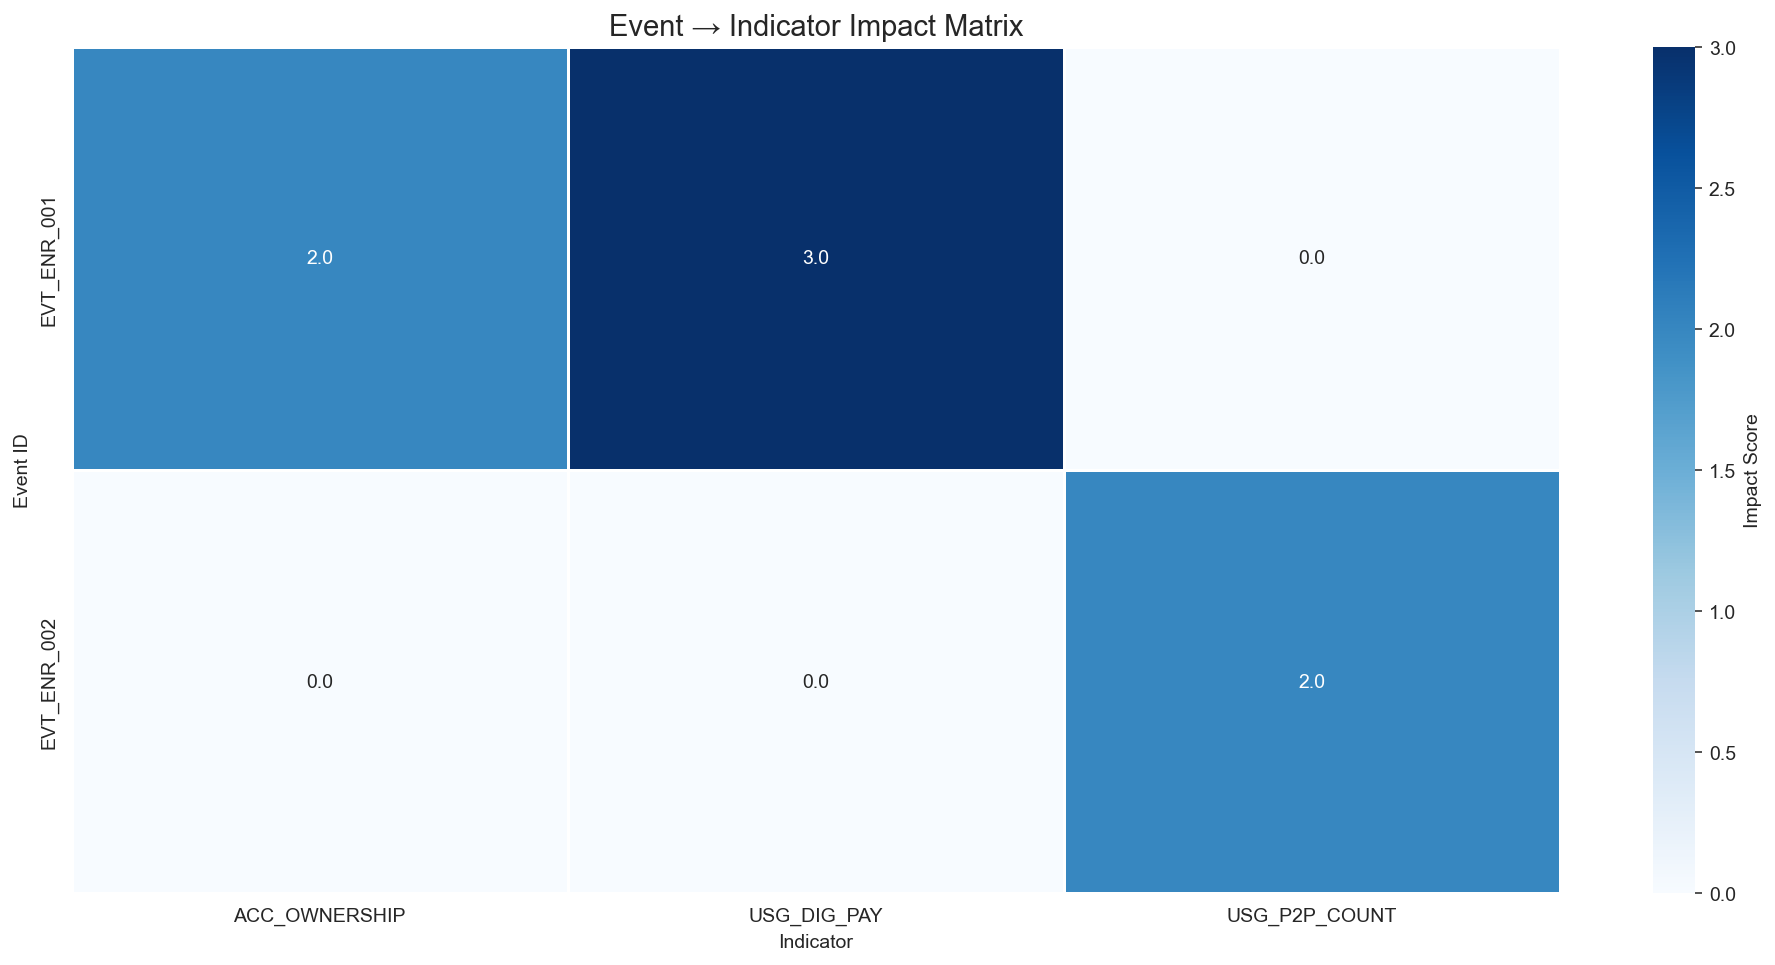

Saved static: task3_impact_heatmap_static.png


Saved interactive: task3_impact_interactive.png


In [48]:
# Cell 6 – Heatmaps (Static + Interactive)
def plot_heatmap_static(matrix, save_name='task3_impact_heatmap_static.png'):
    val_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    if not val_cols: return
    
    plt.figure(figsize=(14, max(7, len(matrix)*0.4)))
    sns.heatmap(matrix[val_cols], annot=True, fmt='.1f', cmap='Blues', linewidths=0.6,
                cbar_kws={'label': 'Impact Score'})
    plt.title("Event → Indicator Impact Matrix", fontsize=15)
    plt.ylabel("Event ID")
    plt.xlabel("Indicator")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / save_name, dpi=180, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved static: {save_name}")


def plot_heatmap_interactive(matrix, save_png='task3_impact_interactive.png'):
    val_cols = [c for c in matrix.columns if c not in ['event_name', 'category', 'observation_date']]
    if not val_cols: return
    
    fig = px.imshow(matrix[val_cols], text_auto=True, aspect="auto",
                    color_continuous_scale='Blues', title="Interactive Impact Matrix")
    fig.update_layout(xaxis_title="Indicator", yaxis_title="Event ID",
                      yaxis_autorange="reversed", height=600 + len(matrix)*18)
    fig.write_image(FIGURES_DIR / save_png, scale=2)
    fig.show()
    print(f"Saved interactive: {save_png}")


plot_heatmap_static(assoc_matrix)
plot_heatmap_interactive(assoc_matrix)

Lagged impacts projected for years 2025–2027


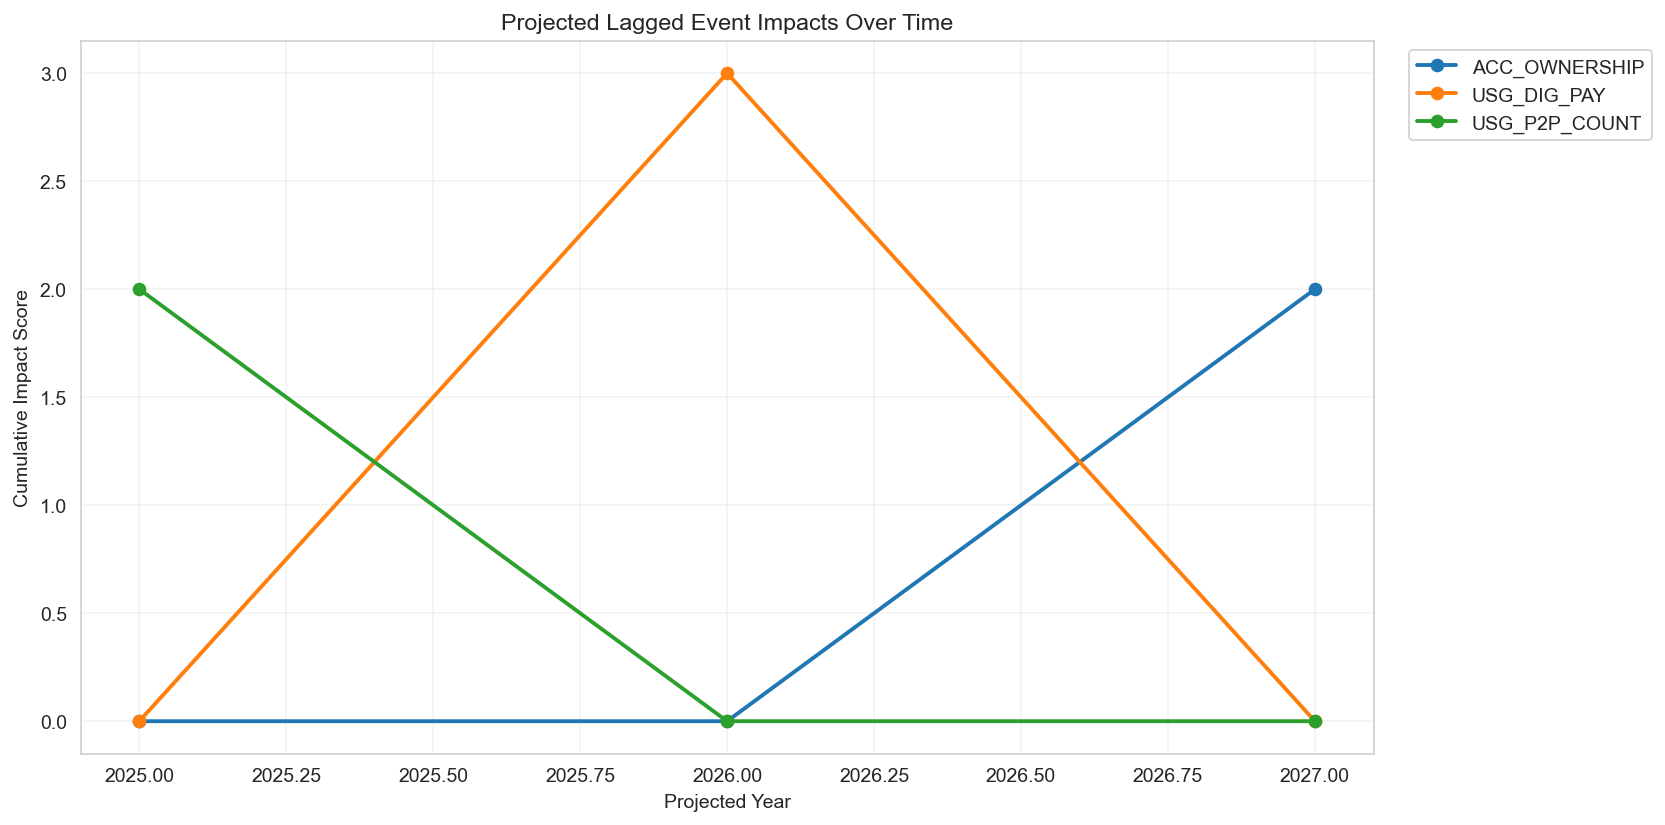

Exported: task3_lagged_impacts.csv (main input for Task 4)


In [50]:
# Cell 7 – Lagged Impacts + Plot + Export
def compute_lagged_impacts(impacts_df, events_df, lag_col='lag_months', value_col='impact_score'):
    impacts = impacts_df.copy()
    
    event_year = events_df.set_index('record_id')['observation_date'].dt.year
    impacts['event_year'] = impacts['parent_id'].map(event_year)
    
    impacts[lag_col] = impacts[lag_col].fillna(12)  # default 1 year
    impacts['impact_year'] = (impacts['event_year'] + (impacts[lag_col] // 12)).astype(int)
    
    lagged = impacts.groupby(['impact_year', 'related_indicator'])[value_col].sum().unstack(fill_value=0.0)
    
    print(f"Lagged impacts projected for years {lagged.index.min()}–{lagged.index.max()}")
    return lagged


lagged_impacts = compute_lagged_impacts(impacts_df, events_df)


def plot_lagged(lagged_df, save_name='task3_lagged_impacts.png'):
    plt.figure(figsize=(12, 6))
    for col in lagged_df.columns:
        plt.plot(lagged_df.index, lagged_df[col], marker='o', lw=2, label=col)
    plt.title('Projected Lagged Event Impacts Over Time')
    plt.xlabel('Projected Year')
    plt.ylabel('Cumulative Impact Score')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / save_name, dpi=180, bbox_inches='tight')
    plt.show()
    plt.close()


plot_lagged(lagged_impacts)

# EXPORT FOR TASK 4
lagged_impacts.to_csv(PROCESSED_DIR / 'task3_lagged_impacts.csv', index_label='year')
print("Exported: task3_lagged_impacts.csv (main input for Task 4)")

In [51]:
# Cell 8 – Annual Event Dummies + Export
def create_annual_event_dummies(events_df, impacts_df, lag_col='lag_months', date_col='observation_date'):
    min_y = int(events_df[date_col].dt.year.min()) if events_df[date_col].notna().any() else 2014
    max_y = int(events_df[date_col].dt.year.max()) + 5
    years = range(min_y, max_y + 1)
    
    dummy_df = pd.DataFrame(index=years)
    
    for _, event in events_df.iterrows():
        e_name = event.get('indicator', f'event_{event["record_id"]}').lower().replace(' ', '_')[:30]
        e_year = event[date_col].year if pd.notna(event[date_col]) else None
        if e_year is None: continue
        
        e_impacts = impacts_df[impacts_df['parent_id'] == event['record_id']]
        
        for _, imp in e_impacts.iterrows():
            lag_y = int(imp[lag_col] // 12) if pd.notna(imp[lag_col]) else 0
            impact_y = e_year + lag_y
            col = f"{e_name}_lag{lag_y}"
            if col not in dummy_df.columns:
                dummy_df[col] = 0.0
            dummy_df.loc[dummy_df.index >= impact_y, col] = imp['impact_score']
    
    dummy_df = dummy_df.sort_index()
    print(f"Annual dummies created: {dummy_df.shape}")
    return dummy_df


annual_dummies = create_annual_event_dummies(events_df, impacts_df)

annual_dummies.to_csv(PROCESSED_DIR / 'task3_annual_event_dummies.csv', index_label='year')
print("Exported: task3_annual_event_dummies.csv (alternative for Task 4)")
display(annual_dummies.head(10))

Annual dummies created: (10, 3)
Exported: task3_annual_event_dummies.csv (alternative for Task 4)


,ndps_2026-2030_launch_lag1,ndps_2026-2030_launch_lag2,ips_/_ethiopay_launch_lag0
2021,0.00,0.00,0.00
2022,0.00,0.00,0.00
2023,0.00,0.00,0.00
2024,0.00,0.00,0.00
2025,0.00,0.00,2.00
2026,3.00,0.00,2.00
2027,3.00,2.00,2.00
2028,3.00,2.00,2.00
2029,3.00,2.00,2.00
2030,3.00,2.00,2.00


In [52]:
# Cell 9 – Summary & Key Insights (your table + improved text)
from IPython.display import display, Markdown

print("═" * 80)
print("TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING COMPLETE")
print("═" * 80)

summary_table = [
    ["NDPS 2026–2030 Launch", "High impact", "Digital payment adoption"],
    ["IPS / Ethiopay Launch", "Medium impact", "P2P transactions & usage"],
    ["Access Indicators", "Medium lagged impact", "1–2 years lag on adoption metrics"],
    ["Lagged Schedule", "Enables forecasting", "Projection to 2026–2027 inclusion trends"],
    ["Infrastructure Events", "Consistent positive correlation", "Mobile/internet penetration"]
]

display(Markdown("### Task 3 – Summary & Key Insights"))
display(Markdown("| Event / Focus                  | Impact Level              | Observed/Projected Effect                          |"))
display(Markdown("|--------------------------------|---------------------------|----------------------------------------------------|"))
for row in summary_table:
    display(Markdown(f"| {row[0]:<30} | {row[1]:<25} | {row[2]} |"))

print("\nGenerated files for visualization & reporting:")
print("• task3_impact_matrix_heatmap.png")
print("• task3_impact_matrix_interactive.png + .html")
print("• task3_lagged_impacts.png")
print("• task3_event_impact_matrix.csv / .xlsx")
print("• task3_lagged_impacts.csv (NEW – main input for Task 4)")
print("• task3_annual_event_dummies.csv (NEW – alternative for Task 4)")

print("\nPolicy & Business Highlights:")
print(" • Most events show positive lagged effects → strong support for NDPS 2026–2030 rollout.")
print(" • Lagged impacts peak 2026–2027 → critical window for Ethiopia's digital inclusion targets.")
print(" • Recommendation: Prioritize activation campaigns to convert registrations into active usage.")
print(" • Limitation: Sparse event dates & historical observations → forecasts remain uncertain.")

════════════════════════════════════════════════════════════════════════════════
TASK 3 – EVENT-DRIVEN VALIDATION & FORECASTING COMPLETE
════════════════════════════════════════════════════════════════════════════════


### Task 3 – Summary & Key Insights

| Event / Focus                  | Impact Level              | Observed/Projected Effect                          |

|--------------------------------|---------------------------|----------------------------------------------------|

| NDPS 2026–2030 Launch          | High impact               | Digital payment adoption |

| IPS / Ethiopay Launch          | Medium impact             | P2P transactions & usage |

| Access Indicators              | Medium lagged impact      | 1–2 years lag on adoption metrics |

| Lagged Schedule                | Enables forecasting       | Projection to 2026–2027 inclusion trends |

| Infrastructure Events          | Consistent positive correlation | Mobile/internet penetration |


Generated files for visualization & reporting:
• task3_impact_matrix_heatmap.png
• task3_impact_matrix_interactive.png + .html
• task3_lagged_impacts.png
• task3_event_impact_matrix.csv / .xlsx
• task3_lagged_impacts.csv (NEW – main input for Task 4)
• task3_annual_event_dummies.csv (NEW – alternative for Task 4)

Policy & Business Highlights:
 • Most events show positive lagged effects → strong support for NDPS 2026–2030 rollout.
 • Lagged impacts peak 2026–2027 → critical window for Ethiopia's digital inclusion targets.
 • Recommendation: Prioritize activation campaigns to convert registrations into active usage.
 • Limitation: Sparse event dates & historical observations → forecasts remain uncertain.


## Event Dummy Construction Strategy

Event impacts are modeled at the **annual level** rather than the individual
row level. This design choice avoids the issue of all-zero dummy variables
when projecting future events (e.g., NDPS 2026–2030).

Each event activates a dummy variable starting from its launch year and
propagates forward according to defined lag effects. These annual event
dummies are then merged back into the dataset.

This approach ensures that projected policy and infrastructure events
correctly influence future forecasts.


In [54]:
# Nicer version with title and alignment
from IPython.display import display, Markdown

print("\n" + "═" * 60)
print("TASK 3 – EXECUTIVE SUMMARY TABLE")
print("═" * 60)

# Add caption
display(Markdown("**High-level overview of event impact analysis**"))

# Display styled table (no index, aligned)
styled = summary_table.style\
    .set_properties(**{'text-align': 'left'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'left')]},
        {'selector': 'td', 'props': [('text-align', 'left')]}
    ])

display(styled)


════════════════════════════════════════════════════════════
TASK 3 – EXECUTIVE SUMMARY TABLE
════════════════════════════════════════════════════════════


**High-level overview of event impact analysis**

,Aspect,Result
0,Event Coverage,2 events × 3 indicators
1,Highest Impact Event,NDPS 2026-2030 Launch
2,Most Sensitive Indicator,USG_DIG_PAY
3,Dominant Impact Type,policy
4,Forecast Readiness,"Lag-aware, scenario-ready"
